In [1]:
# Installing FEniCS (dolfin) on the Google Colab servers
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
from dolfin import *

--2025-05-17 17:18:30--  https://fem-on-colab.github.io/releases/fenics-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4180 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.08K  --.-KB/s    in 0s      

2025-05-17 17:18:30 (49.3 MB/s) - ‘/tmp/fenics-install.sh’ saved [4180/4180]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/a51d633e/releases/pybi

In [2]:
# Importing some libraries
from dolfin import * # This is the core of FEniCS and it contains all the FEM functions we will need
from ufl_legacy.geometry import * # This helps in designing geometries
from dolfin.cpp.mesh import *     # This handles meshes
from mshr import *                # This generates meshes

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

Una rete neurale artificiale è un modello parametrico che definisce una funzione
\(
  F \colon \mathbb{R}^n \longrightarrow \mathbb{R}^m
\)
ottenuta mediante la composizione di più trasformazioni elementari. Ogni trasformazione è composta da uno strato di neuroni artificiali, ciascuno dei quali calcola prima una combinazione lineare degli ingressi
\begin{equation}
  f = w^\top x + \beta
\end{equation}
dove \(w\in\mathbb{R}^n\) è il vettore di parametri o pesi e \(b\in\mathbb{R}\) il bias, e poi applica una funzione di attivazione \(\sigma(f)\) per introdurre non linearità.

In [3]:
class MLP(nn.Module):
    def __init__(self, layers=[2,50,50,50,1]):
        super(MLP, self).__init__()
        self.net = nn.Sequential()
        for i in range(len(layers) - 2):
            self.net.add_module(f"layer_{i}", nn.Linear(layers[i], layers[i+1]))
            self.net.add_module(f"tanh_{i}", nn.Tanh())
        self.net.add_module("output", nn.Linear(layers[-2], layers[-1]))

    def forward(self, x):
        return self.net(x)

# First example

In [4]:
x = np.linspace(0, 1, 1000)
y = np.linspace(0, 1, 1000)
layers = [2, 50, 50, 50, 1]

In [5]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt


def put_zero_row_in_csr(A, row):
    A.data[A.indptr[row]:A.indptr[row+1]] = 0


class Geometry2D:
    def __init__(self, x, y):
        self.x0, self.x1 = x[0], x[-1]
        self.y0, self.y1 = y[0], y[-1]
        self.set_Ns(len(x), len(y))

    def set_Ns(self, Nx, Ny):
        self.Nx, self.Ny = Nx, Ny
        self.dx = (self.x1 - self.x0) / (Nx - 1)
        self.dy = (self.y1 - self.y0) / (Ny - 1)
        x = np.linspace(self.x0, self.x1, Nx)
        y = np.linspace(self.y0, self.y1, Ny)
        self.XX, self.YY = np.meshgrid(x, y, indexing='ij')

    def map_2D_to_1D(self, i, j):
        return i * self.Ny + j


class PoissonProblem2D:
    def __init__(self, geometry, boundary=None, f_lambda=None):
        self.geometry = geometry
        self.boundary = boundary or {
            'left':   ('dirichlet', lambda x, y: 0.0),
            'right':  ('dirichlet', lambda x, y: 0.0),
            'top':    ('dirichlet', lambda x, y: 0.0),
            'bottom': ('dirichlet', lambda x, y: 0.0)
        }
        self.f_lambda = f_lambda or (lambda x, y: np.ones_like(x))

    def assemble(self):
        geom = self.geometry
        Nx, Ny = geom.Nx, geom.Ny
        N = Nx * Ny
        dx, dy = geom.dx, geom.dy

        main = np.ones(N) * (2/dx**2 + 2/dy**2)
        off_x = np.ones(N-Ny) * (-1/dx**2)
        off_y = np.ones(N-1)  * (-1/dy**2)
        A = sp.diags(
            [main, off_x, off_x, off_y, off_y],
            [0, -Ny, Ny, -1, 1],
            shape=(N, N),
            format='csr'
        )

        X = geom.XX.reshape(-1)
        Y = geom.YY.reshape(-1)
        f = self.f_lambda(X, Y)

        self.A = A
        self.f = f
        self.apply_BC()

    def apply_BC(self):
        geom = self.geometry
        A = self.A
        f = self.f
        for side, (btype, bfunc) in self.boundary.items():
            if side == 'left':
                i_range = [0]
                j_range = range(geom.Ny)
            elif side == 'right':
                i_range = [geom.Nx-1]
                j_range = range(geom.Ny)
            elif side == 'top':
                i_range = range(geom.Nx)
                j_range = [geom.Ny-1]
            elif side == 'bottom':
                i_range = range(geom.Nx)
                j_range = [0]
            else:
                raise ValueError(f"Unknown side: {side}")

            for i in i_range:
                for j in j_range:
                    alpha = geom.map_2D_to_1D(i, j)
                    x, y = geom.XX[i, j], geom.YY[i, j]
                    if btype == 'dirichlet':
                        put_zero_row_in_csr(A, alpha)
                        A[alpha, alpha] = 1.0
                        f[alpha] = bfunc(x, y)
                    elif btype == 'neumann':
                        put_zero_row_in_csr(A, alpha)
                        if side == 'left':
                            neighbor = geom.map_2D_to_1D(i+1, j)
                            A[alpha, alpha]    = -1.0/geom.dx
                            A[alpha, neighbor] =  1.0/geom.dx
                        elif side == 'right':
                            neighbor = geom.map_2D_to_1D(i-1, j)
                            A[alpha, alpha]    =  1.0/geom.dx
                            A[alpha, neighbor] = -1.0/geom.dx
                        elif side == 'bottom':
                            neighbor = geom.map_2D_to_1D(i, j+1)
                            A[alpha, alpha]    = -1.0/geom.dy
                            A[alpha, neighbor] =  1.0/geom.dy
                        elif side == 'top':
                            neighbor = geom.map_2D_to_1D(i, j-1)
                            A[alpha, alpha]    =  1.0/geom.dy
                            A[alpha, neighbor] = -1.0/geom.dy
                        f[alpha] = bfunc(x, y)
                    else:
                        raise ValueError(f"Boundary type '{btype}' not supported on {side}")

        self.A = A
        self.f = f

    def solve(self):
        if not hasattr(self, 'A') or not hasattr(self, 'f'):
            self.assemble()
        u_flat = spla.spsolve(self.A, self.f)
        return u_flat.reshape(self.geometry.Nx, self.geometry.Ny)

In [6]:
geom = Geometry2D(x, y)
boundary = {
    'left':   ('dirichlet', lambda x, y: 0),
    'right':  ('dirichlet', lambda x, y: 0),
    'top':    ('neumann', lambda x, y: 0),
    'bottom': ('neumann', lambda x, y: 0)
}
poisson = PoissonProblem2D(geom, boundary=boundary)
u = poisson.solve()

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

class PINNPoisson:
    def __init__(
        self, x, y, layers, bc, f=None,
        epochs=5000, N=(10000, 1000), lr=1e-3, path=None, real_solution = u
    ):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # coordinate arrays
        self.x = np.array(x, dtype=float)
        self.y = np.array(y, dtype=float)
        self.x_min, self.x_max = self.x.min(), self.x.max()
        self.y_min, self.y_max = self.y.min(), self.y.max()

        # boundary conditions: bc[side] = (type_str, fn(x,y)->value)
        self.bc = bc

        # source term
        self.f = f if f is not None else (lambda x, y: 1.0)

        self.epochs = epochs
        self.N_f, self.N_b = N
        self.path = path

        # PINN model
        self.model = MLP(layers).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

        self.U_fd = real_solution

        # evaluation grid for prediction/plotting
        X, Y = np.meshgrid(self.x, self.y, indexing='ij')
        XY = np.hstack([X.flatten()[:,None], Y.flatten()[:,None]])
        self.grid = torch.tensor(XY, dtype=torch.float32, device=self.device)

    def sample_collocation(self):
        x = torch.rand(self.N_f,1, device=self.device)*(self.x_max-self.x_min) + self.x_min
        y = torch.rand(self.N_f,1, device=self.device)*(self.y_max-self.y_min) + self.y_min
        x.requires_grad_(True)
        y.requires_grad_(True)
        return x, y

    def sample_boundary(self):
        N_edge = self.N_b // 4
        edges = {}

        for side in ['left','right','bottom','top']:
            bc_type, bc_fn = self.bc[side]

            # sample points on that side
            if side == 'left':
                y = torch.rand(N_edge,1, device=self.device)*(self.y_max-self.y_min) + self.y_min
                x = torch.full_like(y, self.x_min)
            elif side == 'right':
                y = torch.rand(N_edge,1, device=self.device)*(self.y_max-self.y_min) + self.y_min
                x = torch.full_like(y, self.x_max)
            elif side == 'bottom':
                x = torch.rand(N_edge,1, device=self.device)*(self.x_max-self.x_min) + self.x_min
                y = torch.full_like(x, self.y_min)
            else:  # top
                x = torch.rand(N_edge,1, device=self.device)*(self.x_max-self.x_min) + self.x_min
                y = torch.full_like(x, self.y_max)

            # pack coordinates
            X_e = torch.cat([x, y], dim=1)

            # evaluate boundary function
            raw_val = bc_fn(x, y)
            if torch.is_tensor(raw_val):
                val = raw_val
                # ensure shape (N_edge,1)
                if val.ndim == 1:
                    val = val.unsqueeze(1)
            else:
                val = torch.full((N_edge,1), float(raw_val), device=self.device)

            edges[side] = (X_e, bc_type, val)

            # for Neumann BC we need gradients wrt coords
            if bc_type.lower() == 'neumann':
                X_e.requires_grad_(True)

        return edges

    def pde_residual(self, x, y):
        u = self.model(torch.cat([x, y], dim=1))
        u_x  = autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_xx = autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
        u_y  = autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
        u_yy = autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True)[0]

        f_val = self.f(x, y)
        if not torch.is_tensor(f_val):
            f_val = torch.full_like(u, float(f_val))

        return -(u_xx + u_yy) - f_val

    def compute_loss(self):
        # PDE residual loss
        x_f, y_f = self.sample_collocation()
        res   = self.pde_residual(x_f, y_f)
        loss_f = self.loss_fn(res, torch.zeros_like(res))

        # Boundary loss
        edges = self.sample_boundary()
        loss_b = torch.tensor(0.0, device=self.device)

        # outward‐normal for each side
        normals = {
            'left':   (-1.0,  0.0),
            'right':  (+1.0,  0.0),
            'bottom': ( 0.0, -1.0),
            'top':    ( 0.0, +1.0),
        }

        for side, (X_e, bc_type, val) in edges.items():
            u_pred = self.model(X_e)

            if bc_type.lower() == 'dirichlet':
                # straightforward Dirichlet loss
                loss_b = loss_b + self.loss_fn(u_pred, val)

            else:  # Neumann
                # compute gradient wrt both x and y at the boundary points
                grads = autograd.grad(
                    u_pred, X_e,
                    torch.ones_like(u_pred),
                    create_graph=True
                )[0]                      # shape (N_edge, 2): [u_x, u_y]

                nx, ny = normals[side]     # pick outward normal
                # build ∂u/∂n = nx * u_x + ny * u_y
                du_dn = nx*grads[:, 0:1] + ny*grads[:, 1:2]

                # match to given Neumann data
                loss_b = loss_b + self.loss_fn(du_dn, val)

        return loss_f + loss_b, (loss_f.item(), loss_b.item())


    def Train(self):
        self.model.train()
        for epoch in range(1, self.epochs + 1):
            self.optimizer.zero_grad()
            total_loss, (lf, lb) = self.compute_loss()
            total_loss.backward()
            self.optimizer.step()
            if epoch % (self.epochs // 10 or 1) == 0:
                print(f"Epoch {epoch}/{self.epochs}, "
                      f"Loss_f={lf:.3e}, Loss_b={lb:.3e}")
        if self.path:
            torch.save(self.model.state_dict(), self.path)

    def Pred(self):
        self.model.eval()
        with torch.no_grad():
            u_pred = self.model(self.grid).cpu().numpy()
        Nx, Ny = len(self.x), len(self.y)
        self.U = u_pred.reshape(Nx, Ny)
        return self.U

    def plot_comparison(self):
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 6))

        # PINN result
        im1 = ax1.imshow(
            self.U.T,
            origin='lower',
            extent=[self.x_min, self.x_max, self.y_min, self.y_max],
            aspect='equal'
        )
        ax1.set_title("PINN")
        ax1.set_xlabel("x")
        ax1.set_ylabel("y")
        fig.colorbar(im1, ax=ax1, label="u")

        # Finite-difference result
        im2 = ax2.imshow(
            self.U_fd.T,
            origin='lower',
            extent=[self.x_min, self.x_max, self.y_min, self.y_max],
            aspect='equal'
        )
        ax2.set_title("FD")
        ax2.set_xlabel("x")
        ax2.set_ylabel("y")
        fig.colorbar(im2, ax=ax2, label="u")

        plt.tight_layout()
        plt.show()



/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 500/5000, Loss_f=3.257e-05, Loss_b=5.015e-05
Epoch 1000/5000, Loss_f=2.649e-05, Loss_b=6.836e-05
Epoch 1500/5000, Loss_f=2.039e-05, Loss_b=1.732e-05
Epoch 2000/5000, Loss_f=1.758e-05, Loss_b=1.236e-05
Epoch 2500/5000, Loss_f=2.849e-05, Loss_b=6.892e-04
Epoch 3000/5000, Loss_f=1.584e-05, Loss_b=4.972e-05
Epoch 3500/5000, Loss_f=1.938e-05, Loss_b=2.704e-04
Epoch 4000/5000, Loss_f=1.216e-05, Loss_b=5.431e-06
Epoch 4500/5000, Loss_f=1.140e-05, Loss_b=1.943e-05
Epoch 5000/5000, Loss_f=9.989e-06, Loss_b=4.194e-06


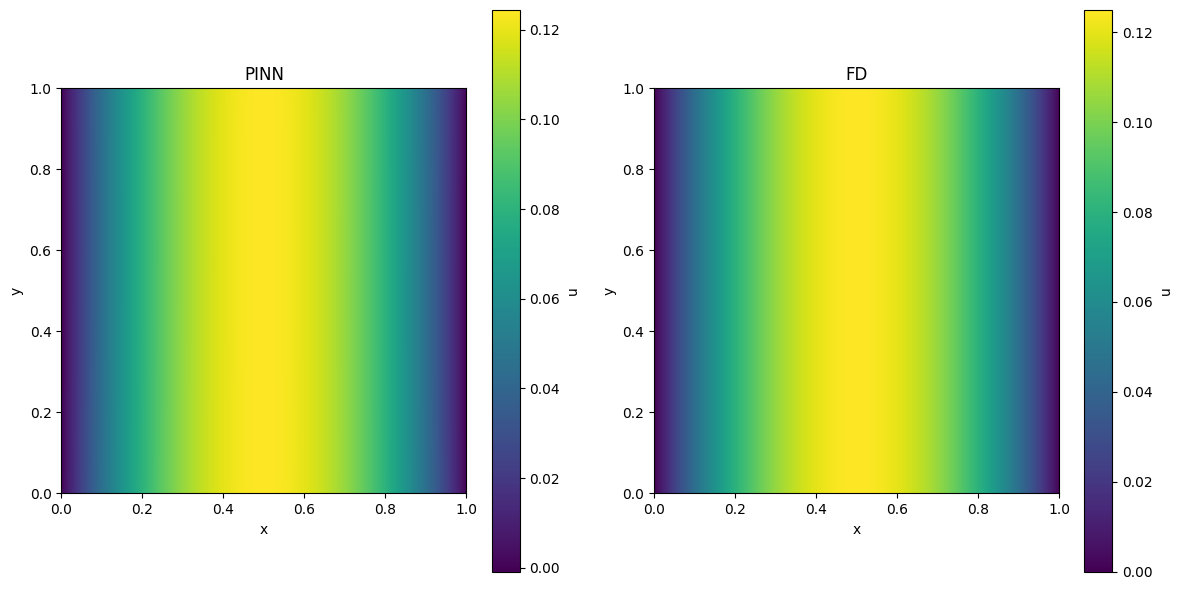

In [8]:
pinn = PINNPoisson(x, y, layers, boundary, epochs=5000)
pinn.Train()
pinn.Pred()
pinn.plot_comparison()

# More complex Geometry

In [ ]:
from dolfin import *
from mshr import Circle, generate_mesh
import matplotlib.pyplot as plt
import matplotlib.tri as tri

# 1) Geometry + mesh --------------------------------------
r_out = 1.0
r_in  = 0.2
outer = Circle(Point(0.0, 0.0), r_out)
inner = Circle(Point(0.0, 0.0), r_in)
domain = outer - inner
mesh = generate_mesh(domain,  128)   # increase 64→128 for finer

# 2) Function space --------------------------------------
V = FunctionSpace(mesh, "CG", 1)

# 3) Boundary conditions ---------------------------------
u0 = Constant(0.0)
u1 = Constant(1.0)
tol = 1e-3

def on_outer(x, on_bnd):
    return on_bnd and near(x[0]**2 + x[1]**2, r_out**2, tol)

def on_inner(x, on_bnd):
    return on_bnd and near(x[0]**2 + x[1]**2, r_in**2, tol)

bc_outer = DirichletBC(V, u0, on_outer)
bc_inner = DirichletBC(V, u1, on_inner)
bcs = [bc_outer, bc_inner]

# 4) Variational problem ---------------------------------
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(1.0)                  # right‐hand side
a = dot(grad(u), grad(v))*dx
L = f*v*dx

u_h = Function(V)
solve(a == L, u_h, bcs)

# 5) Plotting like your figure ---------------------------
#    sample solution onto a structured grid for a smooth contour
npts = 200
x = y = [(-r_out + 2*r_out*(i/(npts-1))) for i in range(npts)]
X, Y = mesh.coordinates().T  # just to get scale

# interpolate to numpy grid
import numpy as np
U = np.zeros((npts, npts))
for i, xi in enumerate(x):
    for j, yj in enumerate(y):
        if r_in <= np.hypot(xi, yj) <= r_out:
            U[j,i] = u_h(Point(xi, yj))
        else:
            U[j,i] = np.nan

In [ ]:
x = np.linspace(-1, 1, 200)
y = np.linspace(-1, 1, 200)
layers = [2, 50, 50, 50, 1]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

class PINN_Donut:
    def __init__(
        self,
        bcs: dict,
        layers=[2,50,50,50,1],
        N_f=10000,
        N_b=2000,
        epochs=5000,
        lr=1e-3,
        device=None,
        real = U
    ):

        self.bcs = bcs
        self.r_in  = bcs['inner']['radius']
        self.r_out = bcs['outer']['radius']

        self.N_f = N_f
        self.N_b = N_b
        self.epochs = epochs
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        # network + optimizer
        self.model = MLP(layers).to(self.device)
        self.optim = optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
        self.U_fem = real
    def sample_collocation(self, N):
        # uniform in annulus by sampling r^2
        theta = torch.rand(N,1, device=self.device) * 2*np.pi
        r = torch.sqrt(
            torch.rand(N,1, device=self.device)*(self.r_out**2 - self.r_in**2)
            + self.r_in**2
        )
        x = r*torch.cos(theta);  y = r*torch.sin(theta)
        x.requires_grad_(True);  y.requires_grad_(True)
        return x, y

    def sample_boundary(self, N_per_bound):
        """Returns a dict of (xb, yb) for each boundary name."""
        out = {}
        for name, cfg in self.bcs.items():
            θ = torch.rand(N_per_bound,1, device=self.device)*2*np.pi
            r = cfg['radius']
            xb = r*torch.cos(θ);  yb = r*torch.sin(θ)
            xb.requires_grad_(True);  yb.requires_grad_(True)
            out[name] = (xb, yb)
        return out

    def pde_residual(self, x, y):
        u = self.model(torch.cat([x, y], dim=1))
        u_x = autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_y = autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_yy = autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
        # Poisson: -Δu = 1  →  Δu + 1 = 0
        return u_xx + u_yy + 1.0

    def compute_loss(self):
        # PDE residual loss
        xf, yf = self.sample_collocation(self.N_f)
        res = self.pde_residual(xf, yf)
        loss_f = self.loss_fn(res, torch.zeros_like(res))

        # Boundary losses
        loss_b = 0.0
        bnds = self.sample_boundary(self.N_b // len(self.bcs))
        for name, cfg in self.bcs.items():
            xb, yb = bnds[name]
            u_pred = self.model(torch.cat([xb, yb], dim=1))

            if cfg['type'].lower() == 'dirichlet':
                # u = value
                target = torch.full_like(u_pred, float(cfg['value']))
                loss_b += self.loss_fn(u_pred, target)

            elif cfg['type'].lower() == 'neumann':
                # ∂u/∂n = value  →  n·∇u
                # normal = (x/r, y/r)
                r = cfg['radius']
                nx = xb / r
                ny = yb / r
                u_x = autograd.grad(u_pred, xb, grad_outputs=torch.ones_like(u_pred),
                                     create_graph=True)[0]
                u_y = autograd.grad(u_pred, yb, grad_outputs=torch.ones_like(u_pred),
                                     create_graph=True)[0]
                dudn = nx*u_x + ny*u_y
                target = torch.full_like(dudn, float(cfg['value']))
                loss_b += self.loss_fn(dudn, target)

            else:
                raise ValueError(f"Unknown BC type {cfg['type']} on '{name}'")

        return loss_f + loss_b, loss_f.item(), loss_b.item()

    def Train(self):
        self.model.train()
        for ep in range(1, self.epochs+1):
            self.optim.zero_grad()
            loss, lf, lb = self.compute_loss()
            loss.backward()
            self.optim.step()
            if ep % (self.epochs//10 or 1) == 0:
                print(f"[{ep:5d}/{self.epochs}]  Total={loss.item():.2e}  PDE={lf:.2e}  BC={lb:.2e}")

    def Pred(self, npts=200):
        xs = np.linspace(-self.r_out, self.r_out, npts)
        ys = np.linspace(-self.r_out, self.r_out, npts)
        X, Y = np.meshgrid(xs, ys)
        U = np.full_like(X, np.nan, dtype=float)

        mask = (X**2 + Y**2 >= self.r_in**2) & (X**2 + Y**2 <= self.r_out**2)
        pts = np.vstack([X[mask], Y[mask]]).T
        with torch.no_grad():
            t = torch.tensor(pts, dtype=torch.float32, device=self.device)
            u_pred = self.model(t).cpu().numpy().ravel()
        U[mask] = u_pred
        return xs, ys, U

    def plot_comparison(self):
        # Get PINN prediction on a grid
        xs, ys, U_pinn = self.Pred(npts)

        # Create a 1×2 subplot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        # PINN plot
        pcm1 = ax1.pcolormesh(xs, ys, U_pinn, shading='auto')
        ax1.set_aspect('equal')
        ax1.set_title("PINN")
        ax1.set_xlabel("x")
        ax1.set_ylabel("y")
        fig.colorbar(pcm1, ax=ax1, label="u")

        # FEM plot
        pcm2 = ax2.pcolormesh(xs, ys, self.U_fem, shading='auto')
        ax2.set_aspect('equal')
        ax2.set_title("FEM")
        ax2.set_xlabel("x")
        ax2.set_ylabel("y")
        fig.colorbar(pcm2, ax=ax2, label="u")

        plt.tight_layout()
        plt.show()

[  500/5000]  Total=2.75e-01  PDE=1.50e-02  BC=2.60e-01
[ 1000/5000]  Total=2.74e-01  PDE=1.73e-02  BC=2.57e-01
[ 1500/5000]  Total=2.73e-01  PDE=1.56e-02  BC=2.58e-01
[ 2000/5000]  Total=2.73e-01  PDE=1.41e-02  BC=2.59e-01
[ 2500/5000]  Total=2.70e-01  PDE=1.84e-02  BC=2.51e-01
[ 3000/5000]  Total=2.68e-01  PDE=2.27e-02  BC=2.45e-01
[ 3500/5000]  Total=7.13e-03  PDE=6.59e-03  BC=5.47e-04
[ 4000/5000]  Total=2.82e-03  PDE=2.73e-03  BC=8.80e-05
[ 4500/5000]  Total=2.39e-03  PDE=2.31e-03  BC=8.55e-05
[ 5000/5000]  Total=1.20e-03  PDE=1.15e-03  BC=4.62e-05


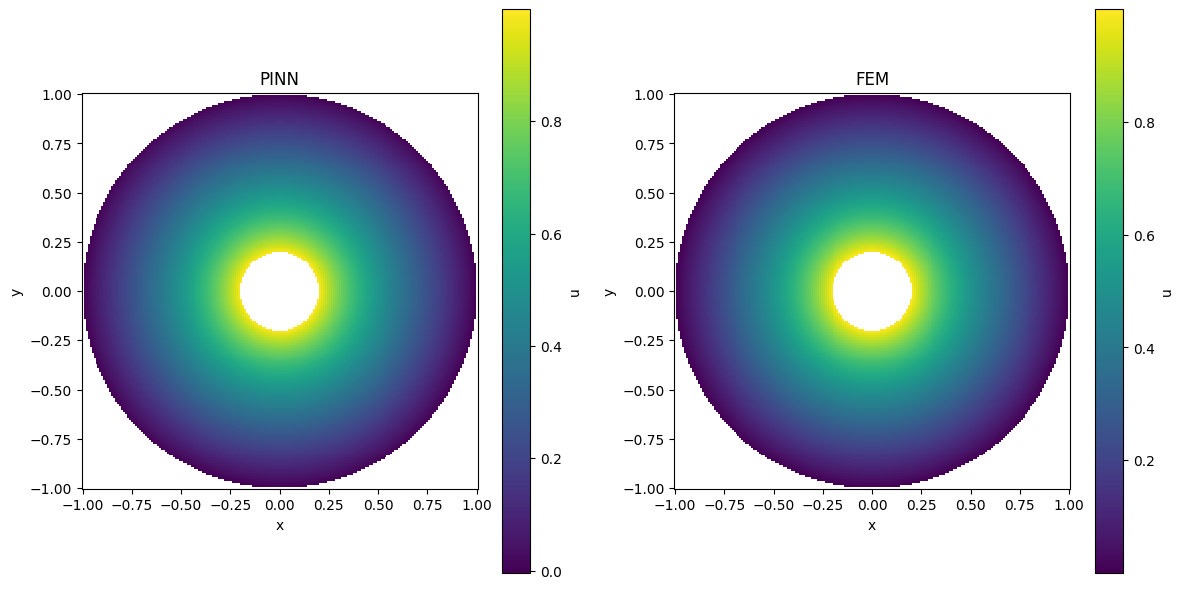

In [ ]:
bcs = {
  'inner': {'type':'dirichlet', 'value':1.0, 'radius':0.2},
  'outer': {'type':'dirichlet',   'value':0.0, 'radius':1.0},
}
pinn = PINN_Donut(bcs, layers=[2,50,50,50,1], N_f=20000, N_b=2000, epochs=5000)
pinn.Train()
pinn.Pred()
pinn.plot_comparison()

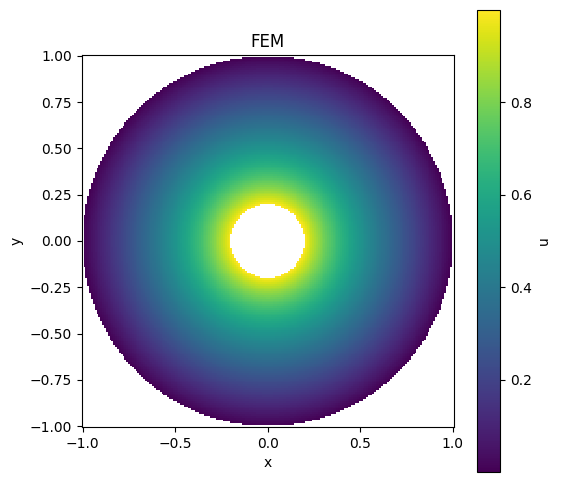

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
c = ax.pcolormesh(x, y, U, shading='auto')
ax.set_aspect('equal')
ax.set_title("FEM")
ax.set_xlabel("x");  ax.set_ylabel("y")
fig.colorbar(c, ax=ax, label="u")
plt.show()

# Time dependent equations

In [ ]:
x = np.linspace(-1, 1, 1000)
t = np.linspace(0, 1, 1000)
u0 = -np.sin(np.pi*x)

In [ ]:
import requests
import io
from io import BytesIO

def load_model_from_github(model_class, url):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    response = requests.get(url)
    response.raise_for_status()
    model = model_class()
    model.load_state_dict(torch.load(BytesIO(response.content), map_location=torch.device(device), weights_only=False))
    model.to(device)
    return model

In [ ]:
class PINN_B:
    def __init__(
        self, u0=u0, x=x, t=t, layers=[2,50,50,50,1],
        epochs=5000, nu=0.01, equation='burgers',
        N = (1000, 1000, 5000), lr = 1e-3, real_solution=None,
        bc_type='dirichlet', path=None
    ):

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.x = np.array(x, dtype=float)
        self.t = np.array(t, dtype=float)
        self.x_min, self.x_max = float(self.x.min()), float(self.x.max())
        self.t_min, self.t_max = float(self.t.min()), float(self.t.max())

        self.u0_np = (u0.copy() if isinstance(u0, np.ndarray)
                      else (u0.detach().cpu().numpy() if torch.is_tensor(u0)
                            else np.array(u0))).reshape(-1)
        self.epochs = epochs
        self.nu = nu
        self.equation = equation.lower()
        self.real_solution = real_solution
        self.bc_type = bc_type.lower()
        X, T = np.meshgrid(self.x, self.t, indexing='ij')
        XT = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
        self.grid = torch.tensor(XT, dtype=torch.float32, device=self.device)
        self.N_ic, self.N_bc, self.N_col = N

        if not path:
            self.model = MLP(layers).to(self.device)
        if path:
            self.model = load_model_from_github(MLP, path)
            self.U_pred = self.Pred()
        self.path = path

        if self.bc_type == 'dirichlet':
            self.bc_left_val, self.bc_right_val = self.u0_np[0], self.u0_np[-1]
        elif self.bc_type == 'neumann':
            self.bc_left_val, self.bc_right_val = self.u0_np[0], self.u0_np[-1]
        elif self.bc_type == 'periodic':
            pass
        else:
            raise ValueError(f"Unknown bc_type '{bc_type}'")

        self.losses = []
        self.loaded = None
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

    def sample_collocation(self, N):
        x = torch.rand(N,1, device=self.device)*(self.x_max-self.x_min) + self.x_min
        t = torch.rand(N,1, device=self.device)*(self.t_max-self.t_min) + self.t_min
        x.requires_grad_(True)
        t.requires_grad_(True)
        return x, t

    def sample_initial(self, N):
        x_ic = torch.rand(N,1, device=self.device)*(self.x_max-self.x_min) + self.x_min
        t_ic = torch.zeros_like(x_ic, device=self.device)

        u0_ic = np.interp(x_ic.cpu().numpy().flatten(), self.x, self.u0_np)
        u0_ic = torch.tensor(u0_ic, dtype=torch.float32, device=self.device).view(-1,1)
        return x_ic, t_ic, u0_ic

    def sample_boundary(self, N):
        t_bc = torch.rand(N,1, device=self.device)*(self.t_max-self.t_min) + self.t_min
        if self.bc_type == 'dirichlet':
            x_left = torch.full_like(t_bc, self.x_min)
            x_right = torch.full_like(t_bc, self.x_max)
            Xb = torch.cat([torch.cat([x_left, t_bc], dim=1),
                            torch.cat([x_right, t_bc], dim=1)], dim=0)
            u_b = torch.cat([
                torch.full_like(t_bc, self.bc_left_val),
                torch.full_like(t_bc, self.bc_right_val)
            ], dim=0).view(-1,1).to(self.device)
            return Xb, u_b

        elif self.bc_type == 'neumann':
            x_left = torch.full_like(t_bc, self.x_min)
            x_right = torch.full_like(t_bc, self.x_max)
            Xb = torch.cat([torch.cat([x_left, t_bc], dim=1),
                            torch.cat([x_right, t_bc], dim=1)], dim=0)
            Xb = Xb.clone().requires_grad_(True)
            dub = torch.cat([
                torch.full_like(t_bc, self.bc_left_val),
                torch.full_like(t_bc, self.bc_right_val)
            ], dim=0).view(-1,1).to(self.device)
            return Xb, dub

        else:  # periodic
            x_left = torch.full_like(t_bc, self.x_min)
            x_right = torch.full_like(t_bc, self.x_max)
            X_lb = torch.cat([x_left, t_bc], dim=1)
            X_rb = torch.cat([x_right, t_bc], dim=1)
            return X_lb, X_rb

    def pde_residual(self, x, t):
        x = x.clone().requires_grad_(True)
        t = t.clone().requires_grad_(True)
        u = self.model(torch.cat([x, t], dim=1))
        u_t = autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x = autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        if self.equation == 'heat':
            return u_t - self.nu * u_xx
        else:
            return u_t + u * u_x - self.nu * u_xx

    def compute_loss(self):
        x_ic, t_ic, u0_ic = self.sample_initial(self.N_ic)
        u_pred_ic = self.model(torch.cat([x_ic, t_ic], dim=1))
        loss_i = self.loss_fn(u_pred_ic, u0_ic)

        if self.bc_type in ['dirichlet', 'neumann']:
            Xb, u_b = self.sample_boundary(self.N_bc)
            if self.bc_type == 'dirichlet':
                u_pred_b = self.model(Xb)
                loss_b = self.loss_fn(u_pred_b, u_b)
            else:
                u_pred = self.model(Xb)
                x_b = Xb[:, :1]
                u_x = autograd.grad(u_pred, x_b, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
                loss_b = self.loss_fn(u_x, u_b)
        else:  # periodic
            X_lb, X_rb = self.sample_boundary(self.N_bc)
            u_lb = self.model(X_lb)
            u_rb = self.model(X_rb)
            loss_b = self.loss_fn(u_lb, u_rb)

        x_f, t_f = self.sample_collocation(self.N_col)
        f_pred = self.pde_residual(x_f, t_f)
        loss_f = self.loss_fn(f_pred, torch.zeros_like(f_pred))

        total_loss = loss_i + loss_b + loss_f
        return total_loss, (loss_i.item(), loss_b.item(), loss_f.item())

    def Train(self):
        self.model.train()
        for ep in range(1, self.epochs + 1):
            self.optimizer.zero_grad()
            loss, (li, lb, lf) = self.compute_loss()
            loss.backward()
            self.optimizer.step()
            self.losses.append((li, lb, lf, loss.item()))
            if ep % (self.epochs // 10 or 1) == 0:
                print(f"PINN: [{ep:5d}/{self.epochs}] | Loss={loss.item():.3e} | PDE={lf:.3e} | BC={lb:.3e} | IC={li:.3e}")
        if self.loaded == False:
            torch.save(self.model.state_dict(), self.path)
            losses = np.array(self.losses)
            np.save(self.path.replace('.pth', '_losses.npy'), losses)

    def Pred(self):
        self.model.eval()
        with torch.no_grad():
            u_pred = self.model(self.grid).cpu().numpy()
        Nx, Nt = len(self.x), len(self.t)
        self.U_pred = u_pred.reshape(Nx, Nt).T
        return self.U_pred

    def plot(self):
        fig, ax = plt.subplots(figsize=(8, 5))
        im = ax.imshow(self.U_pred, extent=[self.x.min(), self.x.max(), self.t.min(), self.t.max()],
                       origin='lower', aspect='auto', cmap='viridis')
        label = 'α' if self.equation == 'heat' else 'ν'
        ax.set_title(rf"PINN $\hat{{u}}(x,t)$ with {label} = {self.nu:.3g}")
        ax.set_xlabel('x'); ax.set_ylabel('t')
        fig.colorbar(im, ax=ax, label=r'$\hat{u}$')
        plt.tight_layout()
        plt.show()


In [ ]:
PINN_3 = PINN_B(
    u0=u0, x=x, t=t, layers=[2, 50, 50, 50, 1],
    epochs=5000, nu=0.01, equation='burgers',
    N=(1000, 1000, 5000), lr=1e-3
)

PINN: [  500/5000] | Loss=8.930e-02 | PDE=3.776e-02 | BC=1.860e-03 | IC=4.967e-02
PINN: [ 1000/5000] | Loss=2.665e-02 | PDE=1.278e-02 | BC=1.197e-03 | IC=1.267e-02
PINN: [ 1500/5000] | Loss=1.424e-02 | PDE=7.279e-03 | BC=4.075e-04 | IC=6.554e-03
PINN: [ 2000/5000] | Loss=9.081e-03 | PDE=5.174e-03 | BC=2.364e-04 | IC=3.670e-03
PINN: [ 2500/5000] | Loss=6.863e-03 | PDE=4.415e-03 | BC=1.163e-04 | IC=2.331e-03
PINN: [ 3000/5000] | Loss=4.279e-03 | PDE=2.665e-03 | BC=7.039e-05 | IC=1.544e-03
PINN: [ 3500/5000] | Loss=3.513e-03 | PDE=2.299e-03 | BC=1.782e-04 | IC=1.036e-03
PINN: [ 4000/5000] | Loss=2.233e-03 | PDE=1.503e-03 | BC=2.947e-05 | IC=7.002e-04
PINN: [ 4500/5000] | Loss=2.437e-03 | PDE=1.802e-03 | BC=7.340e-05 | IC=5.615e-04
PINN: [ 5000/5000] | Loss=2.164e-03 | PDE=1.754e-03 | BC=1.752e-05 | IC=3.933e-04


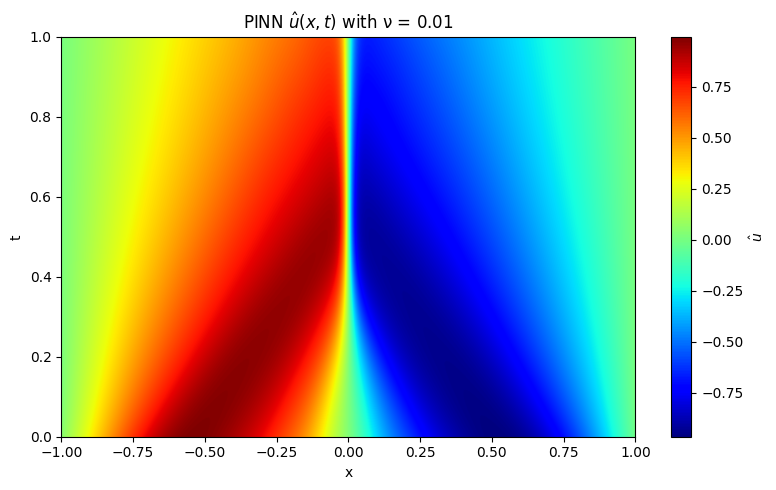

In [ ]:
PINN_3.Train()
PINN_3.Pred()
PINN_3.plot()

In [ ]:
nus = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0001, 1e-4, 1e-8, 1e-12]

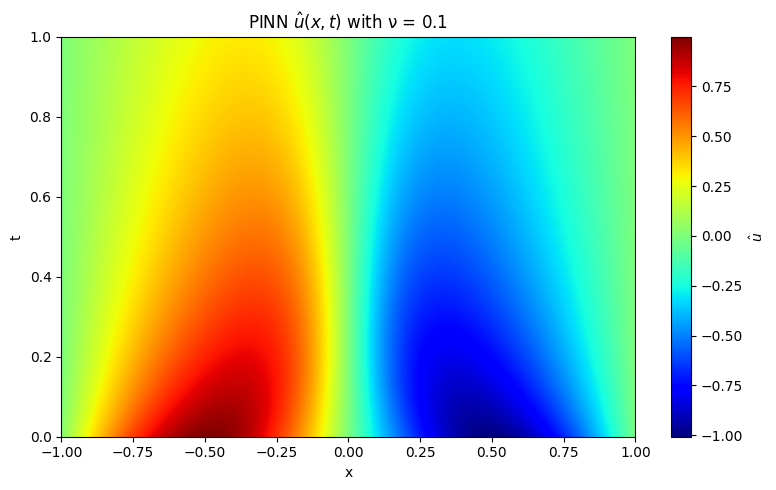

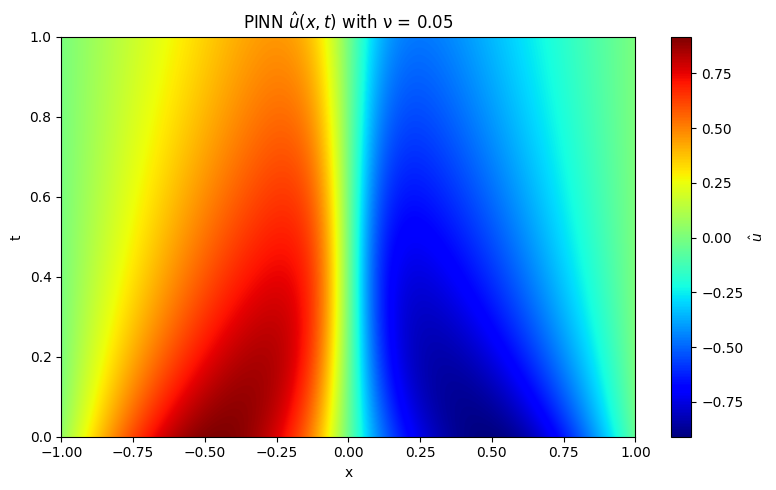

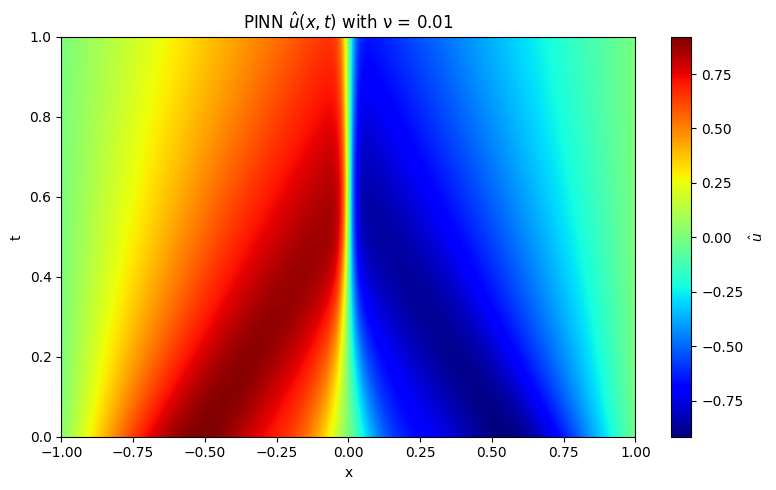

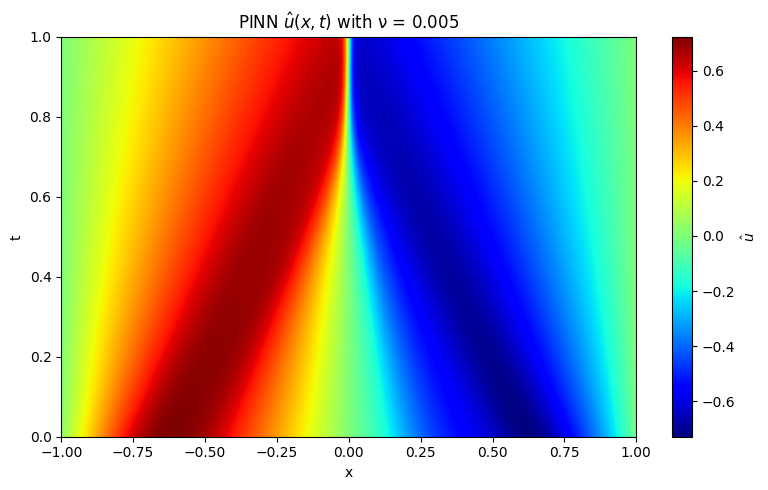

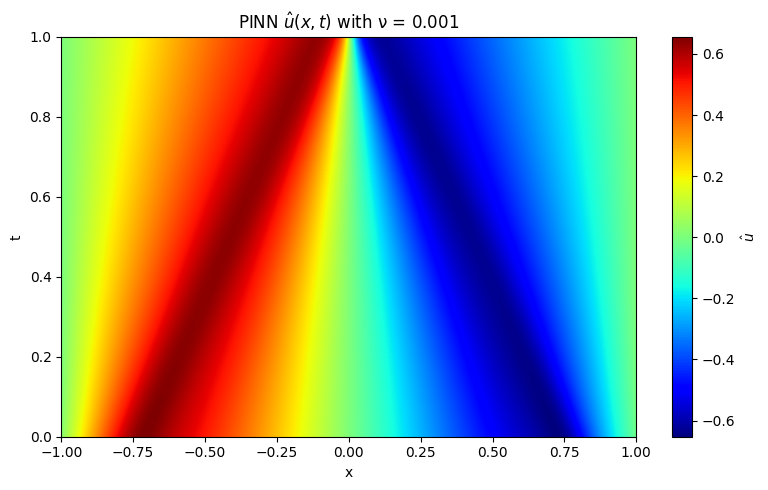

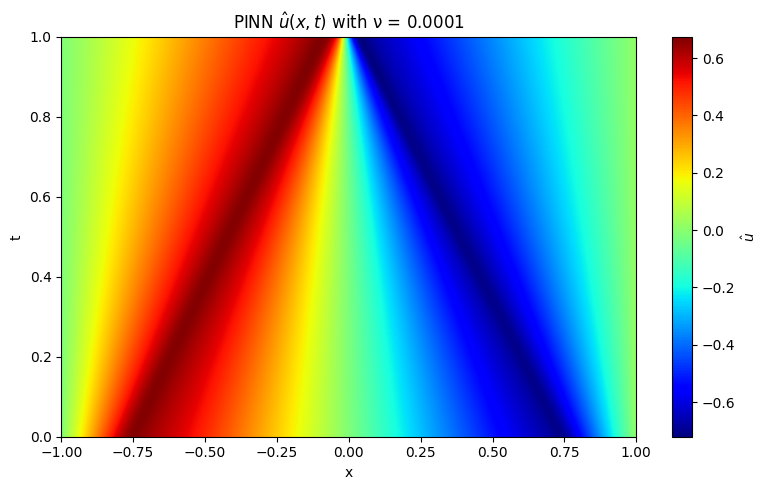

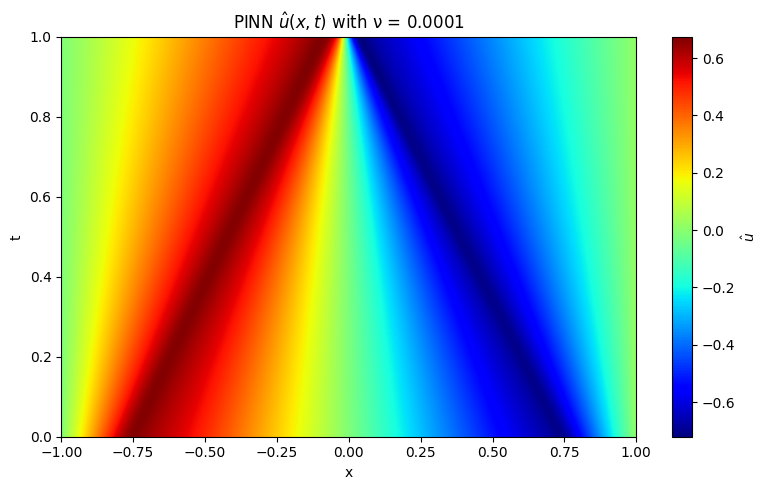

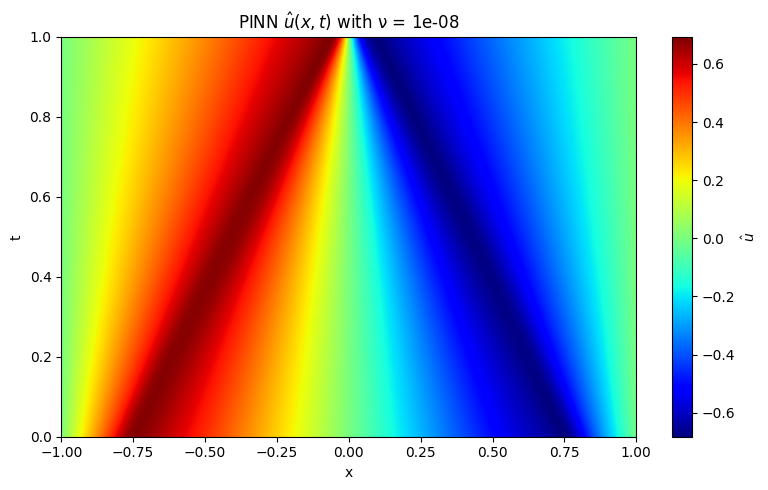

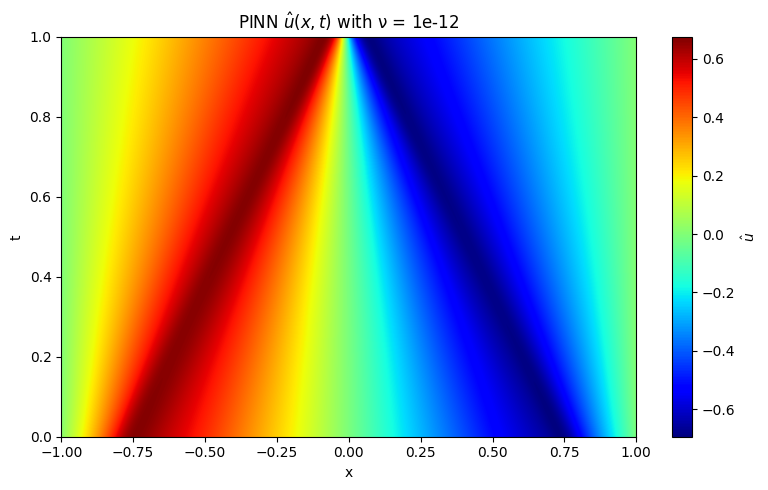

In [ ]:
for nu in nus:
    plotting = PINN_B(nu = nu, path=f"https://raw.github.com/FRAMAX444/PINNs/main/burgers/nu-0/sin_N_C100000_nu{nu}.pth")
    plotting.plot()

# Possible improvements

In [ ]:
class wPINN:
    def __init__(self, u0=u0, x=x, t=t, layers=[2,50,50,50,1], epochs = 5000, N = (1000, 1000, 5000), lr=1e-3,
                 bc_type='dirichlet', lambda_bc=1.0, adv_steps=5, path=None):

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.x = np.array(x, dtype=float)
        self.t = np.array(t, dtype=float)
        self.u0_np = np.array(u0, dtype=float).reshape(-1)
        self.u0 = torch.tensor(self.u0_np, dtype=torch.float32, device=self.device).view(-1,1)

        self.u0_x_np = np.gradient(self.u0_np, self.x)

        self.u0 = torch.tensor(self.u0_np,  dtype=torch.float32, device=self.device).view(-1,1)
        self.u0_x = torch.tensor(self.u0_x_np, dtype=torch.float32, device=self.device).view(-1,1)

        self.t_min, self.t_max = float(self.t[0]), float(self.t[-1])
        self.x_min, self.x_max = float(self.x[0]), float(self.x[-1])

        self.lambda_bc = lambda_bc
        self.adv_steps = adv_steps

        self.u_net   = MLP(layers).to(self.device)
        self.path = path
        self.losses = []
        self.loaded = None
        if self.path is not None:
            try:
                self.u_net = load_model_from_github(MLP, self.path).to(self.device)
                self.U_pred = self.u_net.Pred()
                # self.losses = np.load(self.path.replace('.pth', '_losses.npy'))
                self.loaded = True
            except FileNotFoundError:
                self.loaded = False

        self.phi_net = MLP(layers).to(self.device)
        self.xi_net  = MLP(layers).to(self.device)

        self.opt_u   = torch.optim.Adam(self.u_net.parameters(),   lr=lr)
        self.opt_phi = torch.optim.Adam(self.phi_net.parameters(), lr=lr)
        self.opt_xi  = torch.optim.Adam(self.xi_net.parameters(),  lr=lr)

        T_mesh, X_mesh = np.meshgrid(self.t, self.x, indexing='ij')  # shapes (nt,nx)
        stacked = np.hstack((T_mesh.flatten()[:,None], X_mesh.flatten()[:,None]))  # (nt*nx,2)
        self.grid = torch.tensor(stacked, dtype=torch.float32, device=self.device)
        self.U_pred = None
        self.N_ic, self.N_bc, self.N_int = N
        self.epochs = epochs
        self.bc_type = bc_type.lower()

    def sample_collocation(self, N):
        t = torch.rand(N,1, device=self.device)*(self.t_max-self.t_min) + self.t_min
        x = torch.rand(N,1, device=self.device)*(self.x_max-self.x_min) + self.x_min
        t.requires_grad_(True); x.requires_grad_(True)
        return t, x

    def flux(self, u): return 0.5*u**2

    def cutoff(self, x):
        center = (self.x_min + self.x_max)/2
        radius = (self.x_max - self.x_min)/2
        return 1 - ((x - center)/radius)**2

    def pde_pairing(self, t, x):
        inp = torch.cat([t,x], dim=1)
        u = self.u_net(inp)
        u_t = autograd.grad(u, t, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        f = self.flux(u)
        f_x = autograd.grad(f, x, torch.ones_like(f), retain_graph=True, create_graph=True)[0]

        phi_raw = self.phi_net(inp)
        phi = phi_raw * self.cutoff(x)
        phi_x = autograd.grad(phi, x, torch.ones_like(phi), retain_graph=True, create_graph=True)[0]

        return u_t*phi - f*phi_x, phi_x

    def entropy_pairing(self, t, x):
        inp = torch.cat([t,x], dim=1)
        u = self.u_net(inp)
        e = 0.5*u**2
        q = (1./3.)*u**3
        e_t = autograd.grad(e, t, torch.ones_like(e), retain_graph=True, create_graph=True)[0]
        q_x = autograd.grad(q, x, torch.ones_like(q), retain_graph=True, create_graph=True)[0]

        res_pos = torch.relu(e_t + q_x)
        xi_raw = self.xi_net(inp)
        xi = xi_raw * self.cutoff(x)
        xi_x = autograd.grad(xi, x, torch.ones_like(xi), retain_graph=True, create_graph=True)[0]

        return res_pos*xi, xi_x

    def compute_boundary_loss(self):
        t_bc = torch.rand(self.N_bc, 1, device=self.device) * (self.t_max - self.t_min) + self.t_min

        t_bc_cat = torch.cat([t_bc, t_bc], dim=0)
        x_bc = torch.cat([torch.full_like(t_bc, self.x_min),
                          torch.full_like(t_bc, self.x_max)], dim=0)
        X_bc = torch.cat([t_bc_cat, x_bc], dim=1)

        u_pred = self.u_net(X_bc)

        if self.bc_type == 'dirichlet':
            u_left  = self.u0[0]
            u_right = self.u0[-1]
            u_true  = torch.cat([
                u_left .expand(self.N_bc,1),
                u_right.expand(self.N_bc,1)
            ], dim=0)
            return (u_pred - u_true).pow(2).mean()

        elif self.bc_type == 'neumann':
            Xb = X_bc.clone().requires_grad_(True)
            u_b = self.u_net(Xb)
            u_x = autograd.grad(u_b,
                                Xb[:,1:2],
                                grad_outputs=torch.ones_like(u_b),
                                create_graph=True)[0]

            ux_left  = self.u0_x[0]
            ux_right = self.u0_x[-1]
            g_true   = torch.cat([
                ux_left .expand(self.N_bc,1),
                ux_right.expand(self.N_bc,1)
            ], dim=0)
            return (u_x - g_true).pow(2).mean()

        elif self.bc_type == 'periodic':
            X_lb = torch.cat([t_bc, torch.full_like(t_bc, self.x_min)], dim=1)
            X_rb = torch.cat([t_bc, torch.full_like(t_bc, self.x_max)], dim=1)
            return (self.u_net(X_lb) - self.u_net(X_rb)).pow(2).mean()

        else:
            raise ValueError(f"Unknown bc_type {self.bc_type}")


    def Train(self):
        for epoch in range(1, self.epochs+1):
            for _ in range(self.adv_steps):
                t_int, x_int = self.sample_collocation(self.N_int)
                r_pde, phi_x = self.pde_pairing(t_int, x_int)
                Lu_PDE = (r_pde - 0.5*phi_x**2).mean()
                r_ent, xi_x = self.entropy_pairing(t_int, x_int)
                L_ent = (r_ent - 0.5*xi_x**2).mean()

                self.opt_phi.zero_grad(); (-Lu_PDE).backward(retain_graph=True); self.opt_phi.step()
                self.opt_xi.zero_grad(); (-L_ent).backward(retain_graph=True); self.opt_xi.step()

            t_int, x_int = self.sample_collocation(self.N_int)
            r_pde, phi_x = self.pde_pairing(t_int, x_int)
            Lu_PDE = (r_pde - 0.5*phi_x**2).mean()
            r_ent, xi_x = self.entropy_pairing(t_int, x_int)
            L_ent = (r_ent - 0.5*xi_x**2).mean()

            x_ic = torch.rand(self.N_ic,1, device=self.device)*(self.x_max-self.x_min)+self.x_min
            t_ic = torch.zeros_like(x_ic, device=self.device)
            u_ic = self.u_net(torch.cat([t_ic, x_ic], dim=1))
            u0_ic = np.interp(x_ic.cpu().numpy().flatten(), self.x, self.u0_np)
            u0_ic = torch.tensor(u0_ic, dtype=torch.float32, device=self.device).view(-1,1)
            L_ic = (u_ic - u0_ic).pow(2).mean()

            L_bc = self.compute_boundary_loss()
            loss = Lu_PDE + L_ent + self.lambda_bc*(L_ic + L_bc)
            self.opt_u.zero_grad(); loss.backward(); self.opt_u.step()

            self.losses.append((Lu_PDE.item(), L_ent.item(), L_ic.item(), L_bc.item(), loss.item()))

            if epoch % (self.epochs//10 or 1) == 0:
                print(f"wPINN: [{epoch}/{self.epochs}] | Loss={loss.item():.2e} | PDE={Lu_PDE.item():.2e} | Ent={L_ent.item():.2e} | BC={L_bc.item():.2e} | IC={L_ic.item():.2e}")
        if self.loaded == False:
            torch.save(self.u_net.state_dict(), self.path)
            losses = np.array(self.losses)
            np.save(self.path.replace('.pth', '_losses.npy'), losses)

    def Pred(self):
        self.u_net.eval()
        with torch.no_grad():
            u_pred = self.u_net(self.grid).cpu().numpy()
        nt, nx = len(self.t), len(self.x)
        self.U_pred = u_pred.reshape(nt, nx)
        return self.U_pred

    def plot(self):
        fig, ax = plt.subplots(figsize=(8,5))
        im = ax.imshow(self.U_pred, extent=[self.x.min(), self.x.max(),
                                            self.t.min(), self.t.max()],
                       origin='lower', aspect='auto', cmap='viridis')
        ax.set_title(r"wPINN $\hat{u}(x,t)$")
        ax.set_xlabel('x'); ax.set_ylabel('t')
        fig.colorbar(im, ax=ax, label=r'$\hat{u}$')
        plt.tight_layout(); plt.show()

In [ ]:
wpinn = wPINN(path="https://raw.github.com/FRAMAX444/PINNs/main/burgers/trained_models/wpinn_burgers_inviscid_1_finale.pth")

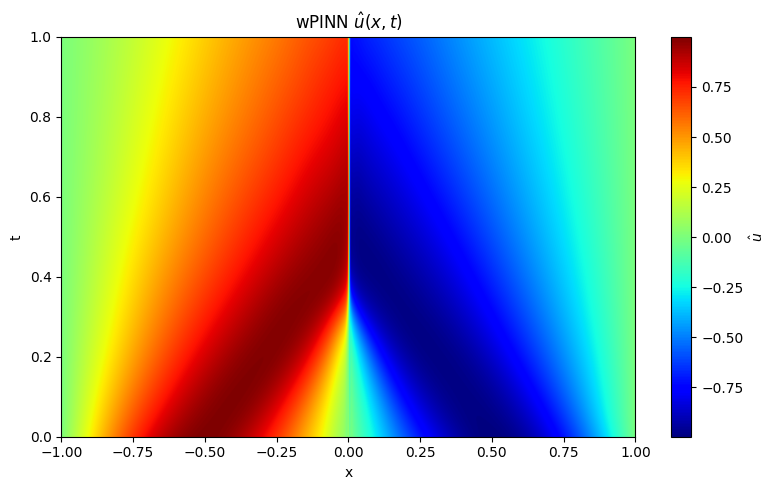

In [ ]:
wpinn.plot()